## 다양한 모델링
- Model : Ensemble
- Log 및 결과 기록 : Sacred

In [1]:
import os
import warnings
from utils import info, split_train_and_test_period, evaluation, split_x_and_y, split_x_and_y_log, parsing_output

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

from sacred import Experiment
from sacred.observers import FileStorageObserver

from xgboost import XGBRegressor


plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
# 실험을 위한 Experiment 객체 생성
ex = Experiment('nyc-demand-prediction', interactive=True)

experiment_dir = os.path.join(os.getcwd(), 'experiments')
if not os.path.isdir(experiment_dir):
    os.mkdir(experiment_dir)

# 실험의 모든 정보를 저장하기 위해 FileStorageObserver 객체를 ex.observers에 저장
ex.observers.append(FileStorageObserver.create(experiment_dir))

### 데이터 로드 & 전처리

In [4]:
base_query = """
WITH base_data AS 
(
    SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
    FROM (
        SELECT *
        FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
        WHERE 
            (EXTRACT(MONTH FROM pickup_datetime) = 1)
            and (pickup_latitude BETWEEN -90 AND 90)
        ) AS nyc_taxi
    JOIN (
        SELECT zip_code, state_code, state_name, city, county, zip_code_geom
        FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
        WHERE state_code='NY'
        ) AS gis 
    ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT
    zip_code,
    pickup_hour,
    EXTRACT(MONTH FROM pickup_hour) AS month,
    EXTRACT(DAY FROM pickup_hour) AS day,
    CAST(format_datetime('%u', pickup_hour) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_hour) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    cnt
FROM (
    SELECT 
        DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
        count(*) AS cnt,
        zip_code
    FROM base_data
    GROUP BY pickup_hour, zip_code
)
ORDER BY pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=info['project'])

### XGBoost Regressor

#### Label Encoding
- baseline modeling 에서 zip_code를 One Hot Encoding 했을 때 Feature Importance가 높은 zip_code가 없었기 때문에 Label Encoding을 진행하여 차원을 줄이는 방향으로 결정

In [51]:
le = LabelEncoder()

base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

#### Data Split

In [52]:
train_df, test_df = split_train_and_test_period(base_df, 7)

In [54]:
x_train, x_test, y_train, y_test = split_x_and_y(train_df, test_df, y='cnt')

#### 모델링_1
- log scaling X

In [7]:
from sklearn.model_selection import RandomizedSearchCV

In [4]:
@ex.config
def config():
    n_estimators = range(100, 900, 100)
    max_depth = [3, 5, 7]
    learning_rate = [0.01, 0.1]
    colsample_bytree = [0.5, 0.75, 1.0]
    min_child_weight = [1.0, 3.0]
    
    
@ex.capture
def get_grid_model(n_estimators, max_depth, learning_rate, colsample_bytree, min_child_weight):
    params = [{
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight
        }]
    rnd_search = RandomizedSearchCV(XGBRegressor(), param_distributions=params, n_iter=100, cv=3,
                                    scoring='neg_mean_squared_error', verbose=1,
                                    n_jobs=os.cpu_count()-2, random_state=13)
    
    return rnd_search


@ex.main
def run(_log, _run):
    global grid_xgb_reg, y_pred
    
    grid_xgb_reg = get_grid_model()
    grid_xgb_reg.fit(x_train, y_train)
    
    y_pred = grid_xgb_reg.best_estimator_.predict(x_test)
    
    score = evaluation(y_test, y_pred)
    
    _run.log_scalar('model_name', grid_xgb_reg.best_estimator_.__class__.__name__)
    _run.log_scalar('model_params', grid_xgb_reg.best_params_)
    _run.log_scalar('score', score)
    
    return score.to_dict()

NameError: name 'ex' is not defined

In [22]:
n_estimators = range(100, 900, 100)
max_depth = [3, 5, 7]
learning_rate = [0.01, 0.1]
colsample_bytree = [0.5, 0.75, 1.0]
min_child_weight = [1.0, 3.0]

params = [{
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight
        }]

rnd_search = RandomizedSearchCV(XGBRegressor(), param_distributions=params, n_iter=100, cv=3,
                                scoring='neg_mean_squared_error', verbose=1,
                                n_jobs=os.cpu_count()-2, random_state=13)

In [33]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "1"


Fitting 3 folds for each of 100 candidates, totalling 300 fits


INFO - nyc-demand-prediction - Result: {'mape': {'score': 240.04097885180414}, 'mae': {'score': 37.741028877026224}, 'mse': {'score': 12603.220104338488}}
INFO - nyc-demand-prediction - Completed after 0:04:17


In [39]:
parsing_output(1)

,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,1,"[{""colsample_bytree"": 1.0, ""learning_rate"": 0....",37.74,240.04,12603.22


In [ ]:
x_train

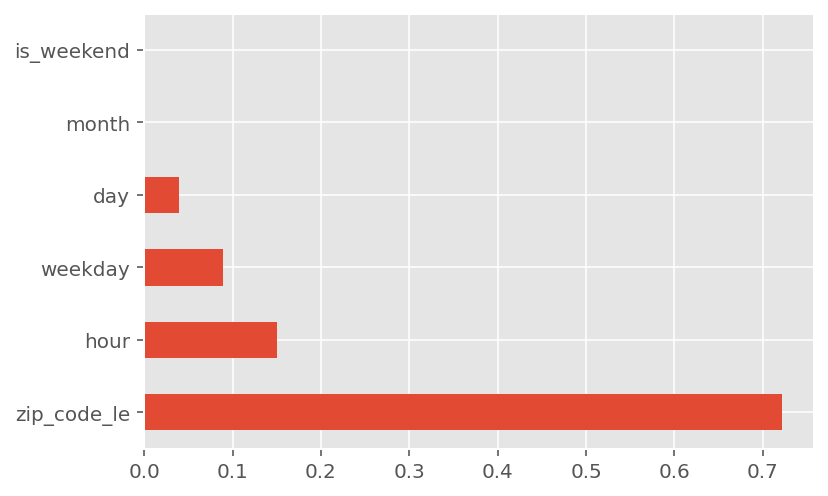

In [55]:
feat_importances = pd.Series(grid_xgb_reg.best_estimator_.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh');

#### 모델링_2
- log scaling 적용

In [3]:
base_df['log_cnt'] = np.log10(base_df['cnt'])

In [4]:
train_df, test_df = split_train_and_test_period(base_df, 7)

In [5]:
x_train, x_test, y_train_log, y_test_raw = split_x_and_y_log(train_df, test_df, y='log_cnt')

In [6]:
x_train.head(3)

,month,day,weekday,hour,is_weekend
0,1,1,3,0,0
1,1,1,3,0,0
2,1,1,3,0,0


In [7]:
y_test_raw.head(3)

65118     4
65119     3
65120    34
Name: cnt, dtype: int64

In [9]:
y_train_log.head(3)

0    1.146128
1    2.923244
2    2.889302
Name: log_cnt, dtype: float64

In [10]:
ex = Experiment('nyc-demand-prediction', interactive=True)

experiment_dir = os.path.join(os.getcwd(), 'experiments')
if not os.path.isdir(experiment_dir):
    os.mkdir(experiment_dir)

ex.observers.append(FileStorageObserver.create(experiment_dir))

In [11]:
@ex.config
def config():
    n_estimators = range(100, 900, 100)
    max_depth = [3, 5, 7]
    learning_rate = [0.01, 0.1]
    colsample_bytree = [0.5, 0.75, 1.0]
    min_child_weight = [1.0, 3.0]
    
    
@ex.capture
def get_grid_model(n_estimators, max_depth, learning_rate, colsample_bytree, min_child_weight):
    params = [{
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight
        }]
    rnd_search = RandomizedSearchCV(XGBRegressor(), param_distributions=params, n_iter=100, cv=3,
                                    scoring='neg_mean_squared_error', verbose=1,
                                    n_jobs=os.cpu_count()-2, random_state=13)
    
    return rnd_search

@ex.main
def run(_log, _run):
    global grid_xgb_reg, y_pred
    
    grid_xgb_reg = get_grid_model()
    grid_xgb_reg.fit(x_train, y_train_log)
    
    y_pred = grid_xgb_reg.best_estimator_.predict(x_test)
    y_pred_reverse = 10**y_pred
    
    score = evaluation(y_test_raw, y_pred_reverse)
    
    _run.log_scalar('model_name', grid_xgb_reg.best_estimator_.__class__.__name__)
    _run.log_scalar('model_params', grid_xgb_reg.best_params_)
    _run.log_scalar('score', score)
    
    return score.to_dict()

In [12]:
experiment_result_2 = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "2"


Fitting 3 folds for each of 100 candidates, totalling 300 fits


INFO - nyc-demand-prediction - Result: {'mape': {'score': 446.72255350854346}, 'mae': {'score': 131.49225080573888}, 'mse': {'score': 103649.73129469037}}
INFO - nyc-demand-prediction - Completed after 0:03:09


In [2]:
pd.concat([parsing_output(1), parsing_output(2)])

,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,1,"[{""colsample_bytree"": 1.0, ""learning_rate"": 0....",37.74,240.04,12603.22
score,XGBRegressor,2,"[{""colsample_bytree"": 0.75, ""learning_rate"": 0...",131.49,446.72,103649.73


- Log Scaling을 한 모델의 성능이 안한 모델보다 성능이 낮기에 Log Scaling은 적용하지 않는다.

### Lightgbm Regressor

In [5]:
le = LabelEncoder()

base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [6]:
train_df, test_df = split_train_and_test_period(base_df, 7)

In [7]:
x_train, x_test, y_train, y_test = split_x_and_y(train_df, test_df, y='cnt')

In [8]:
len(x_train)

65118

In [9]:
from lightgbm import LGBMClassifier

In [10]:
ex = Experiment('nyc-demand-prediction', interactive=True)

experiment_dir = os.path.join(os.getcwd(), 'experiments')
if not os.path.isdir(experiment_dir):
    os.mkdir(experiment_dir)

ex.observers.append(FileStorageObserver.create(experiment_dir))

In [11]:
@ex.config
def config():
    n_estimators = range(100, 900, 100)
    max_depth = [3, 5, 7]
    learning_rate = [0.01, 0.1]
    num_leaves = [31, 50, 70]
    min_data_in_leaf = [20] + [num for num in range(100, 900, 200)]
    
    
@ex.capture
def get_grid_model(n_estimators, max_depth, learning_rate, num_leaves, min_data_in_leaf):
    params = [{
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'num_leaves': num_leaves,
        'min_data_in_leaf': min_data_in_leaf
        }]
    rnd_search = RandomizedSearchCV(LGBMClassifier(), param_distributions=params, n_iter=100, cv=3,
                                    scoring='neg_mean_squared_error', verbose=2,
                                    n_jobs=os.cpu_count()-2, random_state=13)
    
    return rnd_search


@ex.main
def run(_log, _run):
    global grid_lgbm_reg, y_pred
    
    grid_lgbm_reg = get_grid_model()
    grid_lgbm_reg.fit(x_train, y_train)
    
    y_pred = grid_lgbm_reg.best_estimator_.predict(x_test)
    
    score = evaluation(y_test, y_pred)
    
    _run.log_scalar('model_name', grid_lgbm_reg.best_estimator_.__class__.__name__)
    _run.log_scalar('model_params', grid_lgbm_reg.best_params_)
    _run.log_scalar('score', score)
    
    return score.to_dict()

In [ ]:
%%time
experiment_result_3 = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "3"


Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
pd.concat([parsing_output(1), parsing_output(3)])

In [ ]:
feat_importances = pd.Series(grid_lgbm_reg.best_estimator_.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh');

### RandomForest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
ex = Experiment('nyc-demand-prediction', interactive=True)

experiment_dir = os.path.join(os.getcwd(), 'experiments')
if not os.path.isdir(experiment_dir):
    os.mkdir(experiment_dir)

ex.observers.append(FileStorageObserver.create(experiment_dir))

In [ ]:
@ex.config
def config():
    n_estimators = range(100, 900, 100)
    max_depth = [-1, 3, 7]
    learning_rate = [0.01, 0.1]
    num_leaves = [31, 50, 70]
    min_data_in_leaf = [20] + [num for num in range(100, 900, 200)]
    
    
@ex.capture
def get_grid_model(n_estimators, max_depth, learning_rate, num_leaves, min_data_in_leaf):
    params = [{
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'num_leaves': num_leaves,
        'min_data_in_leaf': min_data_in_leaf
        }]
    rnd_search = RandomizedSearchCV(LGBMClassifier(), param_distributions=params, n_iter=100, cv=3,
                                    scoring='neg_mean_squared_error', verbose=1,
                                    n_jobs=os.cpu_count()-2, random_state=13)
    
    return rnd_search


@ex.main
def run(_log, _run):
    global grid_rf_reg, y_pred
    
    grid_rf_reg = get_grid_model()
    grid_rf_reg.fit(x_train, y_train)
    
    y_pred = grid_rf_reg.best_estimator_.predict(x_test)
    
    score = evaluation(y_test, y_pred)
    
    _run.log_scalar('model_name', grid_rf_reg.best_estimator_.__class__.__name__)
    _run.log_scalar('model_params', grid_rf_reg.best_params_)
    _run.log_scalar('score', score)
    
    return score.to_dict()